In [1]:
!pip install torch torchvision torchaudio matplotlib numpy tqdm

In [2]:
# base
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

# helpers
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import v2

In [3]:
plt.style.use('dark_background')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In [5]:
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        self.len_dataset = 0
        self.data_list = []
        
        for path_dir, dir_list, file_list in os.walk(path): # os.walk is GENERATOR func
            # print(f'[WALK]: {path_dir} | {dir_list} | {len(file_list)}')
            
            if path_dir == path:
                self.classes = sorted(os.listdir(path_dir))
                self.class_to_index = { cls_name: i for i, cls_name in enumerate(self.classes) }
                continue
            
            cls = path_dir.split(os.sep)[-1]

            for file_name in file_list:
                file_path = os.path.join(path_dir, file_name)
                self.data_list.append((file_path, self.class_to_index[cls]))
                
            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = Image.open(file_path)
        
        # print(f'[PIL => Sample]: {sample}')
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, target

In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, ), std=(0.5, ))
])

In [7]:
train_dataset = MNISTDataset(path='./mnist/training', transform=transform)
test_dataset = MNISTDataset(path='./mnist/testing', transform=transform)

In [8]:
train_dataset_split, val_dataset = random_split(train_dataset, [0.7, 0.3])
print(f'[Train]: {len(train_dataset_split)}')
print(f'[Validation]: { len(val_dataset)}')
print(f'[Test]: {len(test_dataset)}')

[Train]: 42000
[Validation]: 18000
[Test]: 10000


In [9]:
train_loader = DataLoader(train_dataset_split, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.layer_2 = nn.Linear(128, output_size)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        
        return out

model = MyModel(input_size=784, output_size=10).to(device)

In [11]:
# input = torch.rand([16, 784], dtype=torch.float32).to(device)
# 
# out = model(input)
# out.shape

In [12]:
loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

In [13]:
EPOCHS = 50
count = 0
best_loss = None

train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []

In [14]:
for epoch in range(EPOCHS):

    # INFO model training
    model.train()
    
    running_train_loss = []
    true_answer_counter = 0
    
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # print(f'Number of correct answers: {true_answer_counter}')
        
        # (batch_size, 1, 28, 28) -> (batch_size, 784) |784|size by 1 axis -> input AI
        x = x.reshape(-1, 28*28).to(device)
        
        # (batch_size, int) -> (batch_size, 10), dtype=float32
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)
        
        prediction = model(x) # forward method
        loss = loss_model(prediction, targets) # loss func
        
        # back prapagetion start
        opt.zero_grad() # reset previously calculated gradients
        loss.backward()
        # back prapagetion end
        
        # optimization step
        opt.step()
        
        # INFO training process visualization
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answer_counter += (prediction.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        train_loop.set_description(f'Epoch [{epoch+1}/{EPOCHS}], train_loss_avg: {mean_train_loss:.4f}')

    running_train_acc = true_answer_counter/len(train_dataset_split)
    
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # INFO model validation
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer_counter = 0
        for x, targets in val_loader:
            # (batch_size, 1, 28, 28) -> (batch_size, 784) |784|size by 1 axis -> input AI
            x = x.reshape(-1, 28*28).to(device)
            
            # (batch_size, int) -> (batch_size, 10), dtype=float32
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)
            
            prediction = model(x)
            loss = loss_model(prediction, targets)
            
            # INFO training process visualization
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer_counter += (prediction.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
    
        running_val_acc = true_answer_counter / len(val_dataset)
        
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler._last_lr[0]
        lr_list.append(lr)
            
        print(f'Epoch [{epoch+1}/{EPOCHS}], train_loss: {mean_train_loss:.4f}, train_metric_acc: {running_train_acc:.4f}, val_loss: {mean_val_loss:.4f}, val_metric_acc: {running_val_acc:.4f}, lr: {lr:.4f}')
        
        if best_loss is None:
            best_loss = mean_train_loss

        if mean_train_loss < best_loss: # better best_loss - mean_val_loss > threshold | mean_val_loss < best_loss - best_loss * threshold
            best_loss = mean_train_loss
            count = 0
            
            checkpoint = {
                'class_to_index': train_dataset.class_to_index,
                'state_model': model.state_dict(),
                'state_opt': opt.state_dict(),
                'state_lr_scheduler': lr_scheduler.state_dict(),
                'loss': {
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'best_loss': best_loss,
                },
                'metric': {
                    'train_acc': train_acc,
                    'val_acc': val_acc,
                },
                'lr': lr_list,
                'epoch': {
                    'EPOCHS': EPOCHS,
                    'save_epoch': epoch,
                },
            }
            
            torch.save(checkpoint, f'serialized/classification/classification_model_state_dict_epoch_{epoch+1}.pt')
            print(f'Epoch - {epoch+1}, model has been saved with loss on validation set - {mean_train_loss:.4f}', end='\n\n')
        
        if count >= 10:
            print(f'\033[31m Training stopped at epoch {epoch+1} \033[0m')
            break

        count += 1
            

Epoch [1/50], train_loss: 0.4302, train_metric_acc: 0.8738, val_loss: 0.2849, val_metric_acc: 0.9180, lr: 0.0010


Epoch [2/50], train_loss: 0.2405, train_metric_acc: 0.9291, val_loss: 0.2202, val_metric_acc: 0.9344, lr: 0.0010
Epoch - 2, model has been saved with loss on validation set - 0.2405



Epoch [3/50], train_loss: 0.1735, train_metric_acc: 0.9494, val_loss: 0.1778, val_metric_acc: 0.9486, lr: 0.0010
Epoch - 3, model has been saved with loss on validation set - 0.1735



Epoch [4/50], train_loss: 0.1376, train_metric_acc: 0.9595, val_loss: 0.1591, val_metric_acc: 0.9536, lr: 0.0010
Epoch - 4, model has been saved with loss on validation set - 0.1376



Epoch [5/50], train_loss: 0.1153, train_metric_acc: 0.9648, val_loss: 0.1391, val_metric_acc: 0.9579, lr: 0.0010
Epoch - 5, model has been saved with loss on validation set - 0.1153



Epoch [6/50], train_loss: 0.0985, train_metric_acc: 0.9697, val_loss: 0.1438, val_metric_acc: 0.9577, lr: 0.0010
Epoch - 6, model has been saved with loss on validation set - 0.0985



Epoch [7/50], train_loss: 0.0852, train_metric_acc: 0.9735, val_loss: 0.1283, val_metric_acc: 0.9617, lr: 0.0010
Epoch - 7, model has been saved with loss on validation set - 0.0852



Epoch [8/50], train_loss: 0.0764, train_metric_acc: 0.9768, val_loss: 0.1183, val_metric_acc: 0.9664, lr: 0.0010
Epoch - 8, model has been saved with loss on validation set - 0.0764



Epoch [9/50], train_loss: 0.0678, train_metric_acc: 0.9785, val_loss: 0.1221, val_metric_acc: 0.9661, lr: 0.0010
Epoch - 9, model has been saved with loss on validation set - 0.0678



Epoch [10/50], train_loss: 0.0624, train_metric_acc: 0.9803, val_loss: 0.1098, val_metric_acc: 0.9680, lr: 0.0010
Epoch - 10, model has been saved with loss on validation set - 0.0624



Epoch [11/50], train_loss: 0.0580, train_metric_acc: 0.9814, val_loss: 0.1142, val_metric_acc: 0.9673, lr: 0.0010
Epoch - 11, model has been saved with loss on validation set - 0.0580



Epoch [12/50], train_loss: 0.0513, train_metric_acc: 0.9840, val_loss: 0.1095, val_metric_acc: 0.9701, lr: 0.0010
Epoch - 12, model has been saved with loss on validation set - 0.0513



Epoch [13/50], train_loss: 0.0485, train_metric_acc: 0.9837, val_loss: 0.1314, val_metric_acc: 0.9629, lr: 0.0010
Epoch - 13, model has been saved with loss on validation set - 0.0485



Epoch [14/50], train_loss: 0.0413, train_metric_acc: 0.9864, val_loss: 0.1175, val_metric_acc: 0.9680, lr: 0.0010
Epoch - 14, model has been saved with loss on validation set - 0.0413



Epoch [15/50], train_loss: 0.0410, train_metric_acc: 0.9862, val_loss: 0.1155, val_metric_acc: 0.9699, lr: 0.0010
Epoch - 15, model has been saved with loss on validation set - 0.0410



Epoch [16/50], train_loss: 0.0375, train_metric_acc: 0.9875, val_loss: 0.1218, val_metric_acc: 0.9667, lr: 0.0010
Epoch - 16, model has been saved with loss on validation set - 0.0375



Epoch [17/50], train_loss: 0.0337, train_metric_acc: 0.9885, val_loss: 0.1248, val_metric_acc: 0.9664, lr: 0.0010
Epoch - 17, model has been saved with loss on validation set - 0.0337



Epoch [18/50], train_loss: 0.0324, train_metric_acc: 0.9892, val_loss: 0.1251, val_metric_acc: 0.9687, lr: 0.0001
Epoch - 18, model has been saved with loss on validation set - 0.0324



Epoch [19/50], train_loss: 0.0135, train_metric_acc: 0.9964, val_loss: 0.1022, val_metric_acc: 0.9749, lr: 0.0001
Epoch - 19, model has been saved with loss on validation set - 0.0135



Epoch [20/50], train_loss: 0.0105, train_metric_acc: 0.9975, val_loss: 0.1015, val_metric_acc: 0.9753, lr: 0.0001
Epoch - 20, model has been saved with loss on validation set - 0.0105



Epoch [21/50], train_loss: 0.0097, train_metric_acc: 0.9979, val_loss: 0.1037, val_metric_acc: 0.9746, lr: 0.0001
Epoch - 21, model has been saved with loss on validation set - 0.0097



Epoch [22/50], train_loss: 0.0091, train_metric_acc: 0.9981, val_loss: 0.1032, val_metric_acc: 0.9763, lr: 0.0001
Epoch - 22, model has been saved with loss on validation set - 0.0091



Epoch [23/50], train_loss: 0.0085, train_metric_acc: 0.9985, val_loss: 0.1028, val_metric_acc: 0.9756, lr: 0.0001
Epoch - 23, model has been saved with loss on validation set - 0.0085



Epoch [24/50], train_loss: 0.0080, train_metric_acc: 0.9988, val_loss: 0.1021, val_metric_acc: 0.9752, lr: 0.0001
Epoch - 24, model has been saved with loss on validation set - 0.0080



Epoch [25/50], train_loss: 0.0076, train_metric_acc: 0.9988, val_loss: 0.1047, val_metric_acc: 0.9743, lr: 0.0001
Epoch - 25, model has been saved with loss on validation set - 0.0076



Epoch [26/50], train_loss: 0.0075, train_metric_acc: 0.9988, val_loss: 0.1027, val_metric_acc: 0.9758, lr: 0.0000
Epoch - 26, model has been saved with loss on validation set - 0.0075



Epoch [27/50], train_loss: 0.0061, train_metric_acc: 0.9993, val_loss: 0.1025, val_metric_acc: 0.9756, lr: 0.0000
Epoch - 27, model has been saved with loss on validation set - 0.0061



Epoch [28/50], train_loss: 0.0058, train_metric_acc: 0.9994, val_loss: 0.1027, val_metric_acc: 0.9757, lr: 0.0000
Epoch - 28, model has been saved with loss on validation set - 0.0058



Epoch [29/50], train_loss: 0.0058, train_metric_acc: 0.9994, val_loss: 0.1026, val_metric_acc: 0.9758, lr: 0.0000
Epoch - 29, model has been saved with loss on validation set - 0.0058



Epoch [30/50], train_loss: 0.0058, train_metric_acc: 0.9994, val_loss: 0.1027, val_metric_acc: 0.9758, lr: 0.0000


Epoch [31/50], train_loss: 0.0057, train_metric_acc: 0.9994, val_loss: 0.1027, val_metric_acc: 0.9756, lr: 0.0000
Epoch - 31, model has been saved with loss on validation set - 0.0057



Epoch [32/50], train_loss: 0.0056, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 32, model has been saved with loss on validation set - 0.0056



Epoch [33/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 33, model has been saved with loss on validation set - 0.0055



Epoch [34/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 34, model has been saved with loss on validation set - 0.0055



Epoch [35/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 35, model has been saved with loss on validation set - 0.0055



Epoch [36/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 36, model has been saved with loss on validation set - 0.0055



Epoch [37/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [38/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 38, model has been saved with loss on validation set - 0.0055



Epoch [39/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 39, model has been saved with loss on validation set - 0.0054



Epoch [40/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [41/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [42/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [43/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [44/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [45/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 45, model has been saved with loss on validation set - 0.0054



Epoch [46/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 46, model has been saved with loss on validation set - 0.0054



Epoch [47/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000
Epoch - 47, model has been saved with loss on validation set - 0.0054



Epoch [48/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [49/50], train_loss: 0.0054, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


Epoch [50/50], train_loss: 0.0055, train_metric_acc: 0.9994, val_loss: 0.1028, val_metric_acc: 0.9754, lr: 0.0000


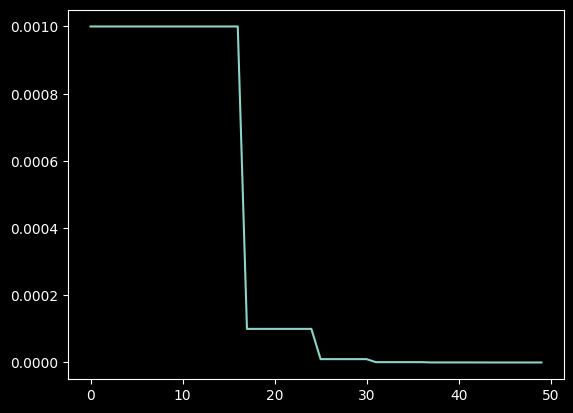

In [15]:
plt.plot(lr_list)
plt.show()

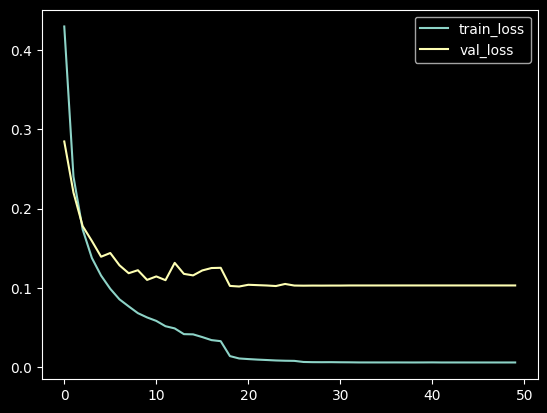

In [16]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

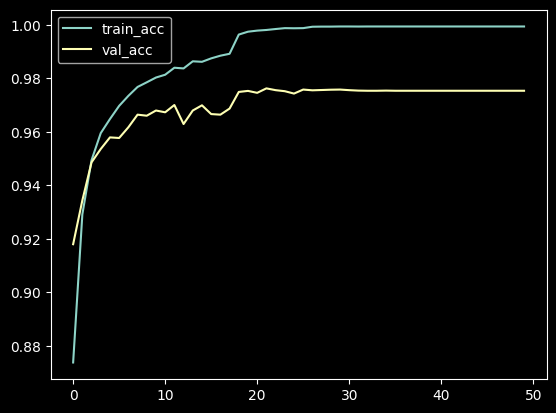

In [17]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [19]:
checkpoint = torch.load(f'serialized/classification/classification_model_state_dict_epoch_47.pt')
model.load_state_dict(checkpoint)

/var/folders/wz/07ctdm5s7rd0j4q2q_5qys5m0000gn/T/ipykernel_3473/3447450064.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'serialized/classific

<All keys matched successfully>

In [20]:
# INFO testing
model.eval()
with torch.no_grad():
    running_test_loss = []
    true_answer_counter = 0
    for x, targets in test_loader:
        # (batch_size, 1, 28, 28) -> (batch_size, 784) |784|size by 1 axis -> input AI
        x = x.reshape(-1, 28*28).to(device)
            
        # (batch_size, int) -> (batch_size, 10), dtype=float32
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)
            
        prediction = model(x)
        loss = loss_model(prediction, targets)
            
        # INFO training process visualization
        running_test_loss.append(loss.item())
        mean_test_loss = sum(running_test_loss)/len(running_test_loss)
            
        true_answer_counter += (prediction.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
    
    running_test_acc = true_answer_counter / len(test_dataset)
    
print(f'test_loss: {mean_test_loss:.4f}, test_metric_acc: {running_test_acc:.4f}', end='\n\n')


test_loss: 0.0867, test_metric_acc: 0.9762

